<a href="https://colab.research.google.com/github/buketugurlu/BUSI/blob/main/BUSI_inception_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install necessary libraries
!pip install segmentation-models-pytorch
!pip install torch torchvision
!pip install scikit-learn

# Import libraries
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Dataset directory
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d63794d4e2b2fecd72a669d24ae6f85484f443487842610bc304051c9d1f82e2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a9b5fc9b35adc48c6ecd50d1f71faa4340dd7813f7db541851ef9d03704b4131
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [5]:
from sklearn.model_selection import train_test_split

# Load all image and mask paths
image_paths = []
mask_paths = []
for cls in ['benign', 'malignant']:
    image_dir = os.path.join(base_dir, cls)
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "_mask" not in filename:
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(image_dir, filename.replace(".png", "_mask.png"))
            image_paths.append(image_path)
            mask_paths.append(mask_path)

# Split into training and temporary (validation + test)
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)  # 70% train, 30% temp (validation + test)

# Split temporary into validation and test
val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)  # 15% validation, 15% test

print(f"Train size: {len(train_images)}, Validation size: {len(val_images)}, Test size: {len(test_images)}")


Train size: 452, Validation size: 97, Test size: 98


In [6]:
# Custom Dataset Class
class BreastUltrasoundDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform_image=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Image and mask transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = BreastUltrasoundDataset(train_images, train_masks, transform_image, transform_mask)
val_dataset = BreastUltrasoundDataset(val_images, val_masks, transform_image, transform_mask)
test_dataset = BreastUltrasoundDataset(test_images, test_masks, transform_image, transform_mask)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


In [7]:
# InceptionV3-based segmentation model
class InceptionSegmentationModel(nn.Module):
    def __init__(self, weights=Inception_V3_Weights.IMAGENET1K_V1, num_classes=1):
        super(InceptionSegmentationModel, self).__init__()
        self.encoder = inception_v3(weights=weights, aux_logits=True)
        self.encoder.aux_logits = False
        self.encoder.avgpool = nn.Identity()
        self.encoder.fc = nn.Identity()
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),
            nn.Conv2d(64, num_classes, kernel_size=1),
        )

    def forward(self, x):
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
        features = self.encoder(x)
        if isinstance(features, tuple):
            features = features[0]
        if len(features.shape) == 2:
            batch_size = features.size(0)
            features = features.view(batch_size, 2048, 8, 8)
        return self.decoder(features)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InceptionSegmentationModel(weights=Inception_V3_Weights.DEFAULT, num_classes=1).to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 177MB/s]


In [8]:
# Loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop with Validation
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_function(predictions, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            predictions = model(images)
            loss = loss_function(predictions, masks)
            val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")


Epoch 1/20, Train Loss: 0.3282, Validation Loss: 0.2016
Epoch 2/20, Train Loss: 0.1811, Validation Loss: 0.1498
Epoch 3/20, Train Loss: 0.1420, Validation Loss: 0.1466
Epoch 4/20, Train Loss: 0.1330, Validation Loss: 0.1547
Epoch 5/20, Train Loss: 0.1028, Validation Loss: 0.1357
Epoch 6/20, Train Loss: 0.0881, Validation Loss: 0.1230
Epoch 7/20, Train Loss: 0.0764, Validation Loss: 0.1275
Epoch 8/20, Train Loss: 0.0686, Validation Loss: 0.1408
Epoch 9/20, Train Loss: 0.0603, Validation Loss: 0.1375
Epoch 10/20, Train Loss: 0.0554, Validation Loss: 0.1294
Epoch 11/20, Train Loss: 0.0514, Validation Loss: 0.1420
Epoch 12/20, Train Loss: 0.0477, Validation Loss: 0.1526
Epoch 13/20, Train Loss: 0.0473, Validation Loss: 0.1391
Epoch 14/20, Train Loss: 0.0485, Validation Loss: 0.1427
Epoch 15/20, Train Loss: 0.0429, Validation Loss: 0.1503
Epoch 16/20, Train Loss: 0.0406, Validation Loss: 0.1409
Epoch 17/20, Train Loss: 0.0417, Validation Loss: 0.1361
Epoch 18/20, Train Loss: 0.0403, Validat

In [9]:
def evaluate_model(dataset, model):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for image, mask in dataset:
            image = image.unsqueeze(0).to(device)
            mask = mask.squeeze().cpu().numpy()
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()
            prediction_binary = (prediction > 0.5).astype(np.uint8)
            all_preds.append(prediction_binary.flatten())
            all_masks.append(mask.flatten())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    dice_score = (2.0 * np.logical_and(y_true, y_pred).sum()) / (y_true.sum() + y_pred.sum() + 1e-6)
    iou = np.logical_and(y_true, y_pred).sum() / (np.logical_or(y_true, y_pred).sum() + 1e-6)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Dice Score: {dice_score:.4f}, IoU: {iou:.4f}")

# Evaluate on test dataset
evaluate_model(test_dataset, model)


Accuracy: 0.9533, Precision: 0.7058, Recall: 0.7234, F1 Score: 0.7145, Dice Score: 0.7145, IoU: 0.5558


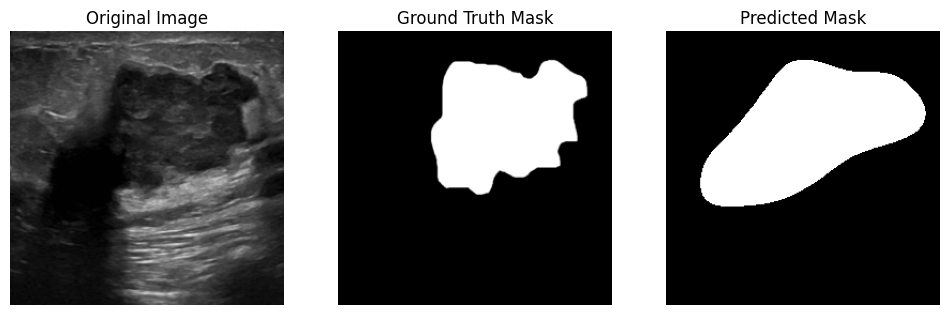

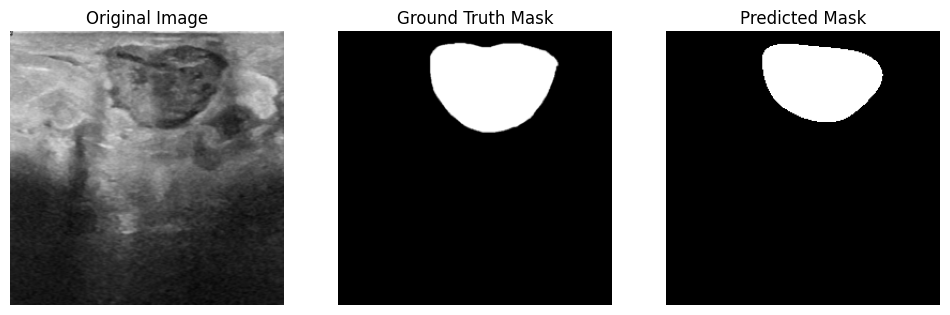

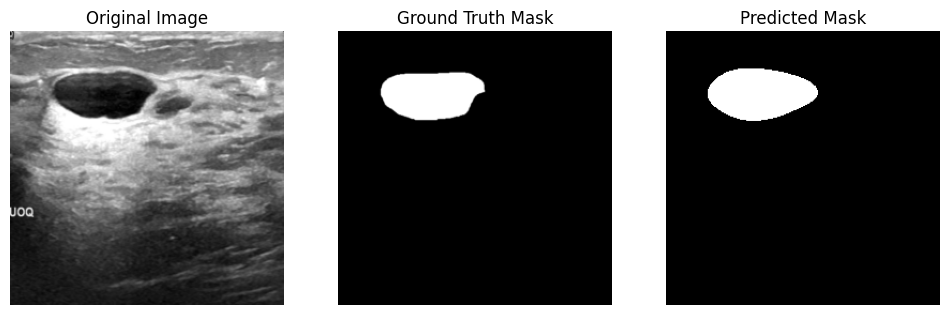

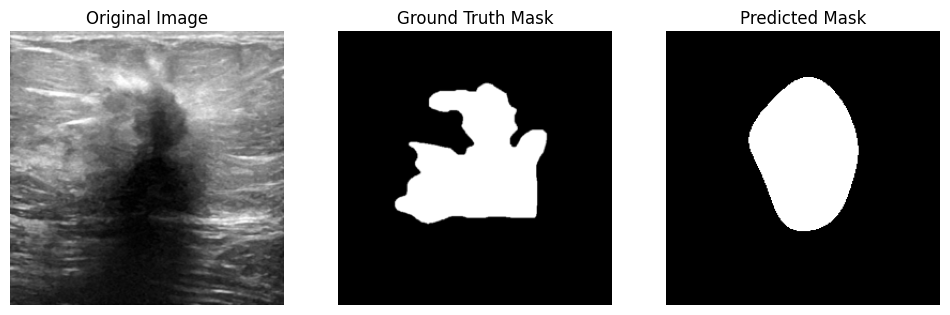

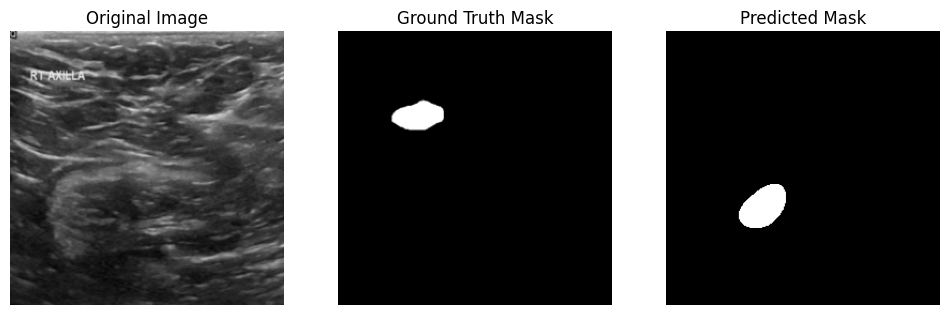

In [10]:
def visualize_predictions(dataset, model, num_samples=5):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()
            prediction_binary = (prediction > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(prediction_binary, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

visualize_predictions(test_dataset, model, num_samples=5)
